In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd


In [3]:
time_series_data = pd.read_csv('AirPassengers.csv')
# convert to numpy array
time_series_data = time_series_data['#Passengers'].values

In [4]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
result = adfuller(time_series_data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Differencing the data if p-value > 0.05 (non-stationary)
diff_data = np.diff(time_series_data)


ADF Statistic: 0.8153688792060463
p-value: 0.991880243437641


In [5]:
def create_sequences(data, n_steps_in, n_steps_out=1):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in])
        y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out])  # Slice for next step
    return np.array(X), np.array(y).reshape(-1, n_steps_out)  # Reshape y properly

# Generate sequences and targets from the differenced data
n_steps_in = 5  # Use last 50 steps to predict the next step
n_steps_out = 1  # Predict 1 step ahead

# Generate sequences from `diff_data`
X, y = create_sequences(diff_data, n_steps_in, n_steps_out)

# Now X and y should have the same number of samples
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (138, 5), y shape: (138, 1)


In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training/validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Further split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=False)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(2)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [7]:
import torch
import torch.nn as nn

class JordanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(JordanRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.rnn = nn.RNN(input_size + 1, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        sequence_length = x.size(1)

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        output = torch.zeros(batch_size, 1, 1).to(x.device)

        for t in range(sequence_length):
            combined_input = torch.cat((x[:, t:t+1, :], output), dim=2)
            out, h0 = self.rnn(combined_input, h0)
            output = self.fc(out)

        return output.squeeze(1)  # Return the final output


Epoch [5/100], Train Loss: 471.3002, Val Loss: 1520.2350
Epoch [10/100], Train Loss: 465.3189, Val Loss: 1501.9968
Epoch [15/100], Train Loss: 459.2377, Val Loss: 1484.1283
Epoch [20/100], Train Loss: 452.8337, Val Loss: 1465.6979
Epoch [25/100], Train Loss: 446.1384, Val Loss: 1446.0245
Epoch [30/100], Train Loss: 439.7220, Val Loss: 1426.0410
Epoch [35/100], Train Loss: 433.9240, Val Loss: 1407.8326
Epoch [40/100], Train Loss: 428.2901, Val Loss: 1392.5276
Epoch [45/100], Train Loss: 422.5579, Val Loss: 1379.5494
Epoch [50/100], Train Loss: 416.8063, Val Loss: 1366.9772
Epoch [55/100], Train Loss: 410.9553, Val Loss: 1352.4250
Epoch [60/100], Train Loss: 404.7633, Val Loss: 1335.6283
Epoch [65/100], Train Loss: 398.0367, Val Loss: 1318.0558
Epoch [70/100], Train Loss: 390.5490, Val Loss: 1299.9235
Epoch [75/100], Train Loss: 382.3507, Val Loss: 1281.5070
Epoch [80/100], Train Loss: 373.3727, Val Loss: 1263.4613
Epoch [85/100], Train Loss: 363.4104, Val Loss: 1247.9395
Epoch [90/100],

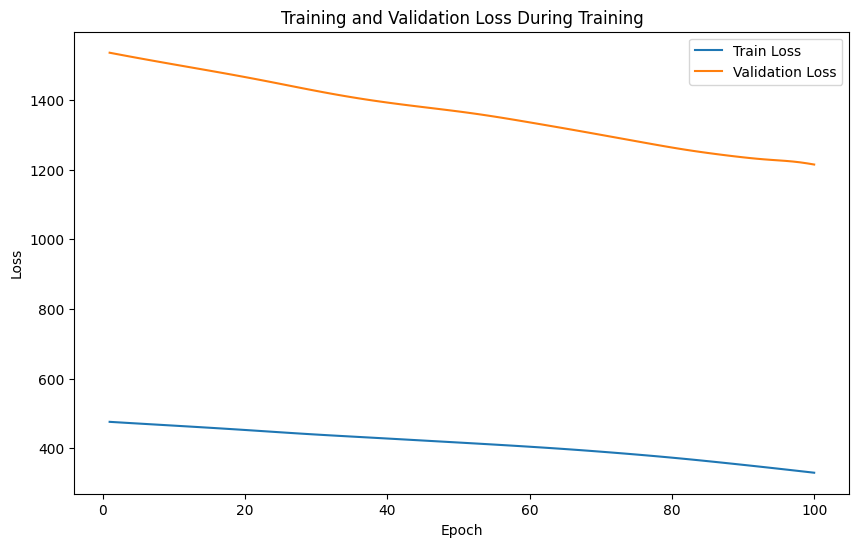

In [8]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Early stopping to stop training when validation loss doesn't improve.
        Args:
        patience (int): How long to wait after last time validation loss improved.
                        Default: 5
        min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                           Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Initialize the model, loss, optimizer, and early stopping
input_size = 1
hidden_size = 64
output_size = 1
num_epochs = 100
learning_rate = 0.001

model = JordanRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

early_stopping = EarlyStopping(patience=10, min_delta=0.001)

import matplotlib.pyplot as plt

# Initialize lists to store the losses
train_losses = []
val_losses = []

# Training loop with early stopping
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass for training
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Store the training loss
    train_losses.append(loss.item())

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    
    # Store the validation loss
    val_losses.append(val_loss.item())

    # Early stopping check
    early_stopping(val_loss.item())
    if early_stopping.early_stop and epoch > 50:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss During Training')
plt.legend()
plt.show()


In [9]:
# Evaluate on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 2560.7913


In [10]:
# Evaluate on the test set
criterion2 = nn.L1Loss()
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion2(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 43.2983


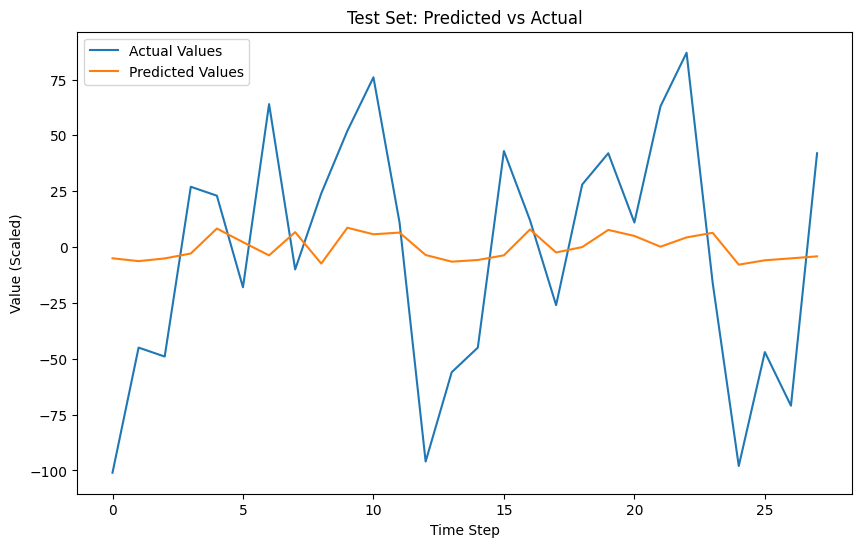

In [11]:
import matplotlib.pyplot as plt
# Plot predicted vs actual values
predicted_test = test_outputs.squeeze().numpy()
actual_test = y_test_tensor.numpy()

plt.figure(figsize=(10, 6))
plt.plot(actual_test, label='Actual Values')
plt.plot(predicted_test, label='Predicted Values')
plt.title('Test Set: Predicted vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Value (Scaled)')
plt.legend()
plt.show()
